# EXP04: Integrated Pipeline Enhancement (V3 통합 실험)

- **Date**: 2026-02-10
- **Prerequisite**: EXP01-v2 (T+M), EXP02-v2 (alpha=0.5, top_k=15), EXP03-v2 (zero_shot_ko)
- **Goal**: Ablation study — 6개 파이프라인 컴포넌트를 누적 추가하며 성능 변화 측정
- **Target Metrics**: Keyword Accuracy (Primary), Faithfulness, Context Recall, Answer Relevancy

## 변경 이력
- EXP01~03 (V1): 기본 파이프라인 최적화 (Chunking → Retrieval → Generation)
- EXP01~03-v2 (V2): T+M 환경 재최적화 → 생성 품질 포화 확인
- **EXP04 (V3)**: 파이프라인 구조 변경으로 성능 한계 돌파 시도

## 1. 실험 설계 (Experiment Design)

### 1.1 실험 배경

V2 실험 라인에서 확인된 핵심 문제:
- **Context Recall 0.73 vs Keyword Accuracy 0.49**: 검색된 컨텍스트에 정답이 있지만 생성에서 ~25% 손실
- **Easy 질문이 가장 낮음**: easy KW_Acc ~0.36 vs hard ~0.80 (역전 현상)
- **"확인 불가" 과다 응답**: 사업명, 수행기간 등 존재하는 정보를 못 찾는 문제
- **원문 축약/변환**: 모델이 정확한 명칭 대신 축약 표현 사용

### 1.2 실험 접근: Ablation Study

6개 컴포넌트를 **누적 추가**하면서 각 요소의 기여도를 측정합니다.

| Config | 이름 | 추가 컴포넌트 | 개선 대상 |
|--------|------|-------------|----------|
| A | baseline | — (EXP03-v2 결과 재사용) | — |
| B | +metadata | 문서 메타데이터 주입 (Fact Sheet) | 생성 (easy Q) |
| C | +verbatim | 원문 인용 강제 프롬프트 | 생성 (KW_Acc) |
| D | +reranker | LLM 기반 Reranker (30→15) | 검색 (Precision) |
| E | +decompose | 질의 분해 (복합 질문 처리) | 검색 (Recall) |
| F | +grading | 관련성 등급 필터링 | 검색+생성 |

### 1.3 고정 변수

| 변수 | 값 | 근거 |
|------|-----|------|
| Chunk Size | 500 | EXP01 최적값 |
| Table Integration (T) | ON | EXP01-v2 |
| Metadata Enrichment (M) | ON | EXP01-v2 |
| Alpha (BM25 weight) | 0.5 | EXP02 확정 |
| Top-K (최종) | 15 | EXP02 확정 |
| Generation LLM | gpt-5-mini | EXP03 동일 |
| Utility LLM | gpt-4o-mini | 리랭킹/분해/등급용 (빠르고 저렴) |

### 1.4 가설

1. **H1**: 문서 메타데이터 주입으로 easy 질문 KW_Acc가 0.36 → 0.55+ 개선
2. **H2**: 원문 인용 프롬프트로 전체 KW_Acc가 0.49 → 0.60+ 개선
3. **H3**: LLM Reranker로 Context Recall 0.73 → 0.80+ 개선
4. **H4**: 질의 분해로 medium/hard 질문 성능 개선
5. **H5**: 전체 파이프라인(F)에서 KW_Acc 0.65+ 달성

### 1.5 메트릭

| 메트릭 | 설명 | Primary |
|--------|------|--------|
| **Keyword Accuracy** | Ground Truth 키워드 포함 비율 (LLM-free) | ★ |
| **Faithfulness** | 답변의 문맥 근거 비율 | ○ |
| **Context Recall** | 검색 품질 (정답 포함 비율) | ○ |
| **Answer Relevancy** | 답변-질문 관련성 | ○ |

In [17]:
# ============================================================
# 2. Setup
# ============================================================
import os
import re
import gc
import json
import time
import shutil
import hashlib
import warnings
from datetime import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdfplumber

from datasets import Dataset
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain_community.retrievers import BM25Retriever

from ragas import evaluate
from ragas.metrics import Faithfulness, ResponseRelevancy, ContextRecall
from ragas.run_config import RunConfig

from bidflow.parsing.preprocessor import TextPreprocessor
from bidflow.eval.ragas_runner import RagasRunner, FixedTempChatOpenAI

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print('[OK] Setup complete')

[OK] Setup complete


In [18]:
# ============================================================
# 3. Config & Data Load
# ============================================================
EXP01V2_REPORT_PATH = '../data/experiments/exp01v2_report.json'
EXP03V2_REPORT_PATH = '../data/experiments/exp03v2_report.json'
GOLDEN_TESTSET_PATH = '../data/experiments/golden_testset.csv'
CHROMA_EXP_PATH = '../data/chroma_exp/exp04'

OUT_REPORT_PATH = '../data/experiments/exp04_report.json'
OUT_CSV_PATH = '../data/experiments/exp04_results.csv'
OUT_FIG_PATH = '../data/experiments/exp04_results.png'

EMBED_MODEL = 'text-embedding-3-small'
GEN_MODEL = 'gpt-5-mini'      # 답변 생성용
UTIL_MODEL = 'gpt-4o-mini'    # 리랭킹/분해/등급 유틸리티용

# ===== EXP01-v2 Prerequisite =====
print('=' * 60)
print('1. EXP01-v2 Prerequisite')
print('=' * 60)

with open(EXP01V2_REPORT_PATH, 'r', encoding='utf-8') as f:
    exp01v2 = json.load(f)

exp01v2_best = exp01v2['best_config']
exp01v2_fixed = exp01v2['meta']['fixed_params']

CHUNK_SIZE = int(exp01v2_fixed.get('chunk_size', 500))
CHUNK_OVERLAP = int(CHUNK_SIZE * 0.1)
ALPHA = float(exp01v2_fixed.get('alpha', 0.5))
TOP_K = int(exp01v2_fixed.get('top_k', 15))

config_str = str(exp01v2_best['config'])
parts = set(config_str.split('+'))
USE_TABLES = 'T' in parts
USE_METADATA = 'M' in parts
EXP01V2_RECALL = float(exp01v2_best['context_recall'])

print(f'  Config: {config_str}, Recall: {EXP01V2_RECALL:.4f}')
print(f'  Chunk: {CHUNK_SIZE}, Alpha: {ALPHA}, Top-K: {TOP_K}')

# ===== EXP03-v2 Baseline (비교용) =====
print(f'\n{"=" * 60}')
print('2. EXP03-v2 Baseline (Config A 재사용)')
print('=' * 60)

exp03v2_baseline = {}
if os.path.exists(EXP03V2_REPORT_PATH):
    with open(EXP03V2_REPORT_PATH, 'r', encoding='utf-8') as f:
        exp03v2 = json.load(f)
    for r in exp03v2['results']:
        exp03v2_baseline[r['strategy']] = {
            'faithfulness': r['faithfulness'],
            'answer_relevancy': r['answer_relevancy'],
            'context_recall': r['context_recall'],
            'keyword_accuracy': r['keyword_accuracy'],
        }
    baseline = exp03v2_baseline.get('zero_shot_ko', {})
    print(f'  zero_shot_ko baseline:')
    print(f'    Faithfulness:     {baseline.get("faithfulness", 0):.4f}')
    print(f'    Keyword Accuracy: {baseline.get("keyword_accuracy", 0):.4f}')
    print(f'    Context Recall:   {baseline.get("context_recall", 0):.4f}')
else:
    print('  [Warning] EXP03-v2 리포트 없음. Baseline 재실행 필요.')

# ===== Golden Testset =====
print(f'\n{"=" * 60}')
print('3. Golden Testset & Sample PDF')
print('=' * 60)

golden_df = pd.read_csv(GOLDEN_TESTSET_PATH)
golden_df = golden_df[~golden_df['ground_truth'].str.contains(r'\[여기에', na=False)]
print(f'  Test cases: {len(golden_df)}')

sample_file = exp01v2['meta'].get('sample_file')
if sample_file and os.path.exists(sample_file):
    SAMPLE_FILE = sample_file
else:
    data_dir = '../data/raw/files'
    pdfs = [f for f in os.listdir(data_dir) if f.lower().endswith('.pdf')]
    SAMPLE_FILE = os.path.join(data_dir, pdfs[0])

print(f'  PDF: {os.path.basename(SAMPLE_FILE)}')

1. EXP01-v2 Prerequisite
  Config: T+M, Recall: 0.7905
  Chunk: 500, Alpha: 0.5, Top-K: 15

2. EXP03-v2 Baseline (Config A 재사용)
  zero_shot_ko baseline:
    Faithfulness:     0.9524
    Keyword Accuracy: 0.4922
    Context Recall:   0.7333

3. Golden Testset & Sample PDF
  Test cases: 30
  PDF: 고려대학교_차세대 포털·학사 정보시스템 구축사업.pdf


## 4. 인덱싱 & 문서 메타데이터 추출

EXP01-v2 T+M 설정으로 인덱스를 구축하고, 동시에 PDF에서 핵심 메타데이터를 LLM으로 추출합니다.

### 문서 메타데이터 (Fact Sheet)
- PDF 첫 **10페이지**에서 "사업 개요", "개요" 등의 섹션을 탐색
- 사업명, 발주처, 사업기간, 예산, 입찰방식 등 핵심 정보를 **원문 그대로** 추출
- 추측/유추 금지 — 문서에 명시적으로 기재된 내용만 추출 (없으면 "미확인")
- **1회 추출** → 모든 질문에 동일 적용

In [19]:
# ============================================================
# Helper Functions (EXP03-v2 동일)
# ============================================================
def robust_rmtree(path):
    if not os.path.exists(path): return
    for _ in range(5):
        try: shutil.rmtree(path); return
        except PermissionError: gc.collect(); time.sleep(1)
        except Exception: return


def table_to_markdown(table_data):
    if not table_data or len(table_data) < 1:
        return ''
    max_cols = max(len(row) for row in table_data)
    rows = []
    for row in table_data:
        clean = []
        for cell in row:
            c = str(cell).strip().replace('\n', ' ').replace('|', '/') if cell else ''
            clean.append(c if c != 'None' else '')
        while len(clean) < max_cols:
            clean.append('')
        rows.append(clean)
    if all(all(c == '' for c in row) for row in rows):
        return ''
    lines = []
    lines.append('| ' + ' | '.join(rows[0]) + ' |')
    lines.append('| ' + ' | '.join(['---'] * max_cols) + ' |')
    for row in rows[1:]:
        lines.append('| ' + ' | '.join(row) + ' |')
    return '\n'.join(lines)


def get_page_for_position(char_idx, page_map):
    for start, end, page_no in page_map:
        if start <= char_idx < end:
            return page_no
    return 1


def strip_meta_prefix(text):
    if text.startswith('[페이지:'):
        nl = text.find('\n')
        if nl >= 0:
            text = text[nl + 1:]
    if text.startswith('[표]\n'):
        text = text[4:]
    return text


def _doc_key(doc):
    meta = getattr(doc, 'metadata', {}) or {}
    chunk_id = meta.get('chunk_id')
    if chunk_id:
        return f'chunk:{chunk_id}'
    digest = hashlib.sha1(doc.page_content.encode('utf-8')).hexdigest()[:16]
    return f'fallback:{digest}'


def rrf_merge(bm25_docs, vector_docs, w_bm25, w_vector, top_k, k=60):
    scores = defaultdict(float)
    doc_map = {}
    for rank, doc in enumerate(bm25_docs):
        key = _doc_key(doc)
        scores[key] += w_bm25 * (1 / (rank + k))
        doc_map[key] = doc
    for rank, doc in enumerate(vector_docs):
        key = _doc_key(doc)
        scores[key] += w_vector * (1 / (rank + k))
        if key not in doc_map:
            doc_map[key] = doc
    sorted_keys = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)
    return [doc_map[k_] for k_ in sorted_keys[:top_k]]


def build_documents(sample_file, chunk_size, chunk_overlap,
                    use_tables=True, use_metadata=True):
    preprocessor = TextPreprocessor()
    with pdfplumber.open(sample_file) as pdf:
        page_texts = []
        page_tables = []
        for i, page in enumerate(pdf.pages):
            raw_text = page.extract_text(layout=True) or ''
            norm = preprocessor.normalize(raw_text)
            page_texts.append((i + 1, norm))
            if use_tables:
                tables = page.extract_tables() or []
                for j, tbl in enumerate(tables):
                    if tbl and any(any(cell for cell in row) for row in tbl):
                        page_tables.append((i + 1, j, tbl))

    full_text = ''
    page_map = []
    for page_no, text in page_texts:
        start = len(full_text)
        full_text += text + '\n\n'
        end = len(full_text)
        page_map.append((start, end, page_no))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap,
        separators=['\n\n', '\n', '.', ' ', '']
    )
    plain_chunks = splitter.split_text(full_text)

    docs = []
    search_from = 0
    for i, c in enumerate(plain_chunks):
        idx = full_text.find(c, search_from)
        if idx < 0:
            idx = full_text.find(c[:80], search_from)
        if idx < 0:
            idx = max(search_from, 0)
        page_no = get_page_for_position(idx, page_map)
        text = f'[페이지: {page_no}]\n{c}' if use_metadata else c
        meta = {'chunk_id': f'text_{i}', 'page_no': page_no, 'content_type': 'text'}
        docs.append(Document(page_content=text, metadata=meta))
        search_from = idx + 1

    if use_tables:
        t_count = 0
        for pg_no, t_idx, tbl in page_tables:
            md = table_to_markdown(tbl)
            if md and len(md.strip()) > 30:
                text = f'[페이지: {pg_no}]\n[표]\n{md}' if use_metadata else f'[표]\n{md}'
                meta = {'chunk_id': f'table_{pg_no}_{t_idx}', 'page_no': pg_no, 'content_type': 'table'}
                docs.append(Document(page_content=text, metadata=meta))
                t_count += 1
        print(f'  Table chunks: +{t_count}')

    return docs, full_text, page_map


def calculate_keyword_accuracy(answers, ground_truths):
    scores = []
    for answer, gt in zip(answers, ground_truths):
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        if not gt_words:
            scores.append(0.0)
            continue
        answer_lower = answer.lower()
        matched = sum(1 for w in gt_words if w in answer_lower)
        scores.append(matched / len(gt_words))
    return float(np.mean(scores))


def extract_metric(val):
    if isinstance(val, (list, tuple)): return float(np.mean(val))
    if hasattr(val, 'mean'): return float(val.mean())
    return float(val) if val is not None else 0.0


def parse_json_response(text):
    """LLM 응답에서 JSON 추출 (markdown 코드블록 처리)"""
    text = text.strip()
    if '```' in text:
        match = re.search(r'```(?:json)?\s*\n?(.*?)\n?```', text, re.DOTALL)
        if match:
            text = match.group(1).strip()
    return json.loads(text)


print('[OK] Helper functions ready')

[OK] Helper functions ready


In [20]:
# ============================================================
# 인덱스 구축 + 문서 메타데이터 추출
# ============================================================
robust_rmtree(CHROMA_EXP_PATH)
os.makedirs(CHROMA_EXP_PATH, exist_ok=True)

print('=' * 60)
print(f'인덱스 구축: T={USE_TABLES}, M={USE_METADATA}')
print('=' * 60)

t0 = time.perf_counter()
docs, full_text, page_map = build_documents(
    SAMPLE_FILE, chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP,
    use_tables=USE_TABLES, use_metadata=USE_METADATA,
)
parse_time = time.perf_counter() - t0

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
vector_db = Chroma(
    persist_directory=CHROMA_EXP_PATH,
    embedding_function=embeddings,
    collection_name='exp04_pipeline',
)

t1 = time.perf_counter()
vector_db.add_documents(docs)
index_time = time.perf_counter() - t1
print(f'[OK] docs={len(docs)}, parse={parse_time:.2f}s, index={index_time:.2f}s')

# ===== 문서 메타데이터 추출 (Fact Sheet) =====
print(f'\n{"=" * 60}')
print('문서 메타데이터 추출 (Fact Sheet)')
print('=' * 60)

# PDF 첫 10페이지 텍스트 추출
# layout=False로 추출하여 공백 최소화 → 더 많은 실질 텍스트 포함
with pdfplumber.open(SAMPLE_FILE) as pdf:
    first_pages = ''
    for i in range(min(10, len(pdf.pages))):
        page_text = pdf.pages[i].extract_text() or ''  # layout=False (기본값)
        first_pages += f'[페이지 {i+1}]\n{page_text}\n\n'

print(f'  추출 텍스트 길이: {len(first_pages)} chars (첫 10페이지)')

util_llm = ChatOpenAI(model=UTIL_MODEL, temperature=0, timeout=60)

meta_prompt = ChatPromptTemplate.from_template(
    """다음은 RFP(제안요청서) 문서의 앞부분입니다.
"사업 개요", "개요", "입찰 공고" 등의 섹션에서 아래 정보를 찾아 **원문 그대로** 추출하세요.

## 추출 규칙
1. 반드시 문서에 **명시적으로 기재된 내용**만 추출하세요. 추측하거나 유추하지 마세요.
2. "사업기간"은 "가.사업기간", "나.사업기간" 등의 항목에서 찾으세요. 문서 발행일이나 공고일이 아닙니다.
   - 예: "계약일로부터 24개월 이내", "2026.03 ~ 2027.02" 등
3. "사업예산"은 "사업예산", "추정가격", "배정예산" 등의 항목에서 찾으세요.
4. "입찰방식"은 "입찰 및 계약 방법", "입찰방식", "계약방법" 등의 항목에서 찾으세요.
5. 문서에서 찾을 수 없는 항목은 반드시 "미확인"으로 표기하세요.

{text}

다음 JSON 형식으로 정확히 반환하세요 (다른 텍스트 없이):
{{
    "사업명": "정식 사업명 (원문 그대로)",
    "발주처": "발주 기관명 (원문 그대로)",
    "사업기간": "수행 기간 (원문 그대로, 문서 발행일 아님)",
    "사업예산": "총 예산 금액 (원문 그대로)",
    "입찰방식": "입찰 및 계약 방식 (원문 그대로)"
}}"""
)

meta_chain = meta_prompt | util_llm | StrOutputParser()
meta_response = meta_chain.invoke({'text': first_pages[:15000]})
doc_metadata = parse_json_response(meta_response)

# Fact Sheet 문자열 생성
fact_sheet_lines = []
for key, val in doc_metadata.items():
    if val and val != '미확인':
        fact_sheet_lines.append(f'- {key}: {val}')
FACT_SHEET = '\n'.join(fact_sheet_lines)

print(f'[OK] Fact Sheet 추출 완료:')
print(FACT_SHEET)

인덱스 구축: T=True, M=True
  Table chunks: +414
[OK] docs=1005, parse=26.04s, index=5.93s

문서 메타데이터 추출 (Fact Sheet)
  추출 텍스트 길이: 6775 chars (첫 10페이지)
[OK] Fact Sheet 추출 완료:
- 사업명: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
- 발주처: 고려대학교
- 사업기간: 계약일로부터 24개월 이내
- 사업예산: 11,270,000,000원 (V.A.T 포함, 3년 분할 지급)
- 입찰방식: 제한 경쟁 입찰(협상에 의한 계약)


## 5. V3 컴포넌트 구현

### 5.1 LLM Reranker
- 1차 검색 (top_k=30) → LLM 배치 스코어링 → 상위 15개 선정
- `gpt-4o-mini`로 각 청크의 관련성 0-10 평가 (질문당 1회 LLM 호출)

### 5.2 Query Decomposition
- 복합 질문을 1-3개 검색 쿼리로 분해
- 각 쿼리별 독립 검색 후 결과 병합 (중복 제거)

### 5.3 Relevance Grading
- 검색된 각 청크를 관련/무관으로 분류
- 관련 청크가 부족하면 질의 재작성 후 재검색

In [21]:
# ============================================================
# V3 컴포넌트 구현
# ============================================================

def llm_rerank(query, doc_list, util_llm, top_k=15):
    """LLM 기반 배치 리랭커: 각 문서의 관련성을 0-10으로 평가"""
    if len(doc_list) <= top_k:
        return doc_list

    # 청크 요약 (토큰 절약을 위해 300자로 제한)
    summaries = []
    for i, doc in enumerate(doc_list):
        content = strip_meta_prefix(doc.page_content)[:300].replace('\n', ' ')
        summaries.append(f'[{i}] {content}')

    prompt = f"""질문: {query}

다음 문서들의 질문에 대한 관련성을 0-10으로 평가하세요.
10 = 질문의 정답이 직접 포함됨, 0 = 전혀 무관.

{chr(10).join(summaries)}

JSON 배열로만 반환 (다른 텍스트 없이): [{{"id": 0, "s": 8}}, ...]"""

    try:
        result = util_llm.invoke(prompt)
        scores = parse_json_response(result.content)
        score_map = {item['id']: item['s'] for item in scores}
        scored = [(doc_list[i], score_map.get(i, 0)) for i in range(len(doc_list))]
        scored.sort(key=lambda x: x[1], reverse=True)
        return [d for d, _ in scored[:top_k]]
    except Exception as e:
        print(f'    [Rerank fallback] {e}')
        return doc_list[:top_k]


def decompose_query(question, util_llm):
    """복합 질문을 1-3개 검색 쿼리로 분해"""
    prompt = f"""다음 RFP 관련 질문을 검색에 최적화된 1-3개의 검색 쿼리로 분해하세요.
간단한 질문(사업명, 기간, 예산 등)은 원본 질문만 반환하세요.
복합 질문은 각 정보를 개별 검색할 수 있도록 분해하세요.

질문: {question}

JSON 배열로만 반환: ["쿼리1", "쿼리2"]"""

    try:
        result = util_llm.invoke(prompt)
        queries = parse_json_response(result.content)
        return queries if isinstance(queries, list) and queries else [question]
    except Exception as e:
        print(f'    [Decompose fallback] {e}')
        return [question]


def grade_and_filter(query, doc_list, util_llm, min_relevant=5):
    """관련성 등급 판정 후 필터링"""
    summaries = []
    for i, doc in enumerate(doc_list):
        content = strip_meta_prefix(doc.page_content)[:200].replace('\n', ' ')
        summaries.append(f'[{i}] {content}')

    prompt = f"""질문: {query}

각 문서가 질문의 답변에 도움이 되는지 판단하세요.

{chr(10).join(summaries)}

JSON 배열로만 반환: [{{"id": 0, "rel": true}}, ...]"""

    try:
        result = util_llm.invoke(prompt)
        grades = parse_json_response(result.content)
        relevant_ids = {g['id'] for g in grades if g.get('rel', False)}
        relevant_docs = [doc_list[i] for i in range(len(doc_list)) if i in relevant_ids]

        if len(relevant_docs) >= min_relevant:
            return relevant_docs
        # 부족하면 원본 상위 문서 사용
        return doc_list[:max(min_relevant, len(relevant_docs) + 3)]
    except Exception as e:
        print(f'    [Grading fallback] {e}')
        return doc_list


print('[OK] V3 components ready')
print(f'  - llm_rerank: LLM 기반 배치 리랭킹')
print(f'  - decompose_query: 질의 분해')
print(f'  - grade_and_filter: 관련성 등급 필터링')

[OK] V3 components ready
  - llm_rerank: LLM 기반 배치 리랭킹
  - decompose_query: 질의 분해
  - grade_and_filter: 관련성 등급 필터링


In [22]:
# ============================================================
# 프롬프트 템플릿 & Ablation 설정
# ============================================================

# --- A: Baseline (EXP03-v2 zero_shot_ko 동일) ---
PROMPT_BASELINE = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 규칙
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""

# --- B: +Metadata (Fact Sheet 주입) ---
PROMPT_METADATA = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보 (사전 확인)
{fact_sheet}

## 규칙
- 위의 '문서 기본 정보'에 해당하는 질문이면 해당 정보를 우선 활용하세요.
- 문맥에 없는 정보는 절대 추측하지 말고 "확인 불가"라고 답하세요.
- 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
- 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""

# --- C~F: +Verbatim (원문 인용 강제) ---
PROMPT_VERBATIM = """당신은 RFP(제안요청서) 분석 전문가입니다.
주어진 문맥(Context)만을 근거로 질문에 답변하세요.

## 문서 기본 정보 (사전 확인)
{fact_sheet}

## 규칙
1. 위의 '문서 기본 정보'에 해당하는 질문이면 해당 정보를 우선 활용하세요.
2. 사업명, 기관명, 기간, 금액 등은 문서 원문의 표현을 **그대로** 사용하세요. 축약하거나 바꾸어 말하지 마세요.
3. "확인 불가"라고 답하기 전에, 문맥에서 질문과 관련된 정보를 한 번 더 찾아보세요.
4. 숫자, 날짜, 금액 등 정량 정보는 원문 그대로 인용하세요.
5. 답변은 간결하게 핵심만 적으세요.

## 문맥
{context}

## 질문
{question}

## 답변"""

# ===== Ablation Configs =====
ABLATION_CONFIGS = {
    'A_baseline': {
        'desc': 'V2 Baseline (zero_shot_ko)',
        'prompt': PROMPT_BASELINE,
        'use_fact_sheet': False,
        'reranker': False,
        'decompose': False,
        'grading': False,
        'initial_k': TOP_K,  # RRF에서 최종 반환 수
    },
    'B_metadata': {
        'desc': '+Document Metadata',
        'prompt': PROMPT_METADATA,
        'use_fact_sheet': True,
        'reranker': False,
        'decompose': False,
        'grading': False,
        'initial_k': TOP_K,
    },
    'C_verbatim': {
        'desc': '+Verbatim Prompt',
        'prompt': PROMPT_VERBATIM,
        'use_fact_sheet': True,
        'reranker': False,
        'decompose': False,
        'grading': False,
        'initial_k': TOP_K,
    },
    'D_reranker': {
        'desc': '+LLM Reranker',
        'prompt': PROMPT_VERBATIM,
        'use_fact_sheet': True,
        'reranker': True,
        'decompose': False,
        'grading': False,
        'initial_k': TOP_K * 2,  # 30개 후보에서 15개로 리랭킹
    },
    'E_decompose': {
        'desc': '+Query Decomposition',
        'prompt': PROMPT_VERBATIM,
        'use_fact_sheet': True,
        'reranker': True,
        'decompose': True,
        'grading': False,
        'initial_k': TOP_K * 2,
    },
    'F_full': {
        'desc': '+Relevance Grading (Full)',
        'prompt': PROMPT_VERBATIM,
        'use_fact_sheet': True,
        'reranker': True,
        'decompose': True,
        'grading': True,
        'initial_k': TOP_K * 2,
    },
}

print(f'[OK] {len(ABLATION_CONFIGS)}개 Ablation 설정 정의')
for key, cfg in ABLATION_CONFIGS.items():
    flags = []
    if cfg['use_fact_sheet']: flags.append('meta')
    if cfg['reranker']: flags.append('rerank')
    if cfg['decompose']: flags.append('decomp')
    if cfg['grading']: flags.append('grade')
    print(f'  {key}: {cfg["desc"]}  [{"|".join(flags) if flags else "none"}]')

[OK] 6개 Ablation 설정 정의
  A_baseline: V2 Baseline (zero_shot_ko)  [none]
  B_metadata: +Document Metadata  [meta]
  C_verbatim: +Verbatim Prompt  [meta]
  D_reranker: +LLM Reranker  [meta|rerank]
  E_decompose: +Query Decomposition  [meta|rerank|decomp]
  F_full: +Relevance Grading (Full)  [meta|rerank|decomp|grade]


In [23]:
# ============================================================
# 통합 실험 실행 함수
# ============================================================
ragas_runner = RagasRunner()
run_cfg = RunConfig(timeout=300, max_retries=5, max_wait=300, max_workers=2)


def retrieve_for_config(question, config, vector_db, bm25_retriever, util_llm):
    """Config에 따른 검색 파이프라인"""
    initial_k = config['initial_k']
    fetch_k = initial_k * 2  # 각 retriever에서 가져올 후보 수

    if config['decompose']:
        sub_queries = decompose_query(question, util_llm)
        all_docs = []
        seen_keys = set()
        for sq in sub_queries:
            bm25_docs = bm25_retriever.invoke(sq)
            vec_docs = vector_db.as_retriever(
                search_kwargs={'k': fetch_k}
            ).invoke(sq)
            merged = rrf_merge(bm25_docs, vec_docs,
                               ALPHA, 1.0 - ALPHA, initial_k)
            for d in merged:
                key = _doc_key(d)
                if key not in seen_keys:
                    seen_keys.add(key)
                    all_docs.append(d)
        retrieved = all_docs[:initial_k]
    else:
        bm25_docs = bm25_retriever.invoke(question)
        vec_docs = vector_db.as_retriever(
            search_kwargs={'k': fetch_k}
        ).invoke(question)
        retrieved = rrf_merge(bm25_docs, vec_docs,
                              ALPHA, 1.0 - ALPHA, initial_k)

    if config['reranker']:
        retrieved = llm_rerank(question, retrieved, util_llm, top_k=TOP_K)

    if config['grading']:
        retrieved = grade_and_filter(question, retrieved, util_llm)

    return retrieved[:TOP_K]


def run_ablation_experiment(config_name, config, golden_df, vector_db,
                            bm25_retriever, fact_sheet):
    """단일 Ablation Config 실험 실행"""
    print(f'\n{"=" * 60}')
    print(f'[{config_name}] {config["desc"]}')
    print(f'{"=" * 60}')

    start_time = time.perf_counter()
    gen_llm = FixedTempChatOpenAI(model=GEN_MODEL, timeout=180, max_retries=3)
    util_llm = ChatOpenAI(model=UTIL_MODEL, temperature=0, timeout=120)

    # 프롬프트 구성
    prompt_template = config['prompt']
    prompt = ChatPromptTemplate.from_template(prompt_template)
    chain = prompt | gen_llm | StrOutputParser()

    questions, ground_truths, contexts_list, answers = [], [], [], []
    per_question_data = []

    for idx, row in golden_df.iterrows():
        q = row['question']
        gt = str(row['ground_truth'])

        # 1. 검색
        retrieved = retrieve_for_config(q, config, vector_db,
                                        bm25_retriever, util_llm)
        contexts_raw = [strip_meta_prefix(d.page_content) for d in retrieved]
        context_text = '\n\n'.join(contexts_raw)

        # 2. 생성
        try:
            invoke_params = {'context': context_text, 'question': q}
            if config['use_fact_sheet']:
                invoke_params['fact_sheet'] = fact_sheet
            answer = chain.invoke(invoke_params)
        except Exception as e:
            print(f'  Generation Error ({q[:20]}...): {e}')
            answer = 'Error'

        questions.append(q)
        ground_truths.append(gt)
        contexts_list.append(contexts_raw)
        answers.append(answer)

        per_question_data.append({
            'question': q,
            'ground_truth': gt,
            'answer': answer,
            'category': row.get('category', ''),
            'difficulty': row.get('difficulty', ''),
            'num_contexts': len(contexts_raw),
        })

    gen_time = time.perf_counter() - start_time
    print(f'  답변 생성 완료: {len(answers)}개 ({gen_time:.1f}s)')

    # 3. Keyword Accuracy (LLM-free, 즉시)
    kw_accuracy = calculate_keyword_accuracy(answers, ground_truths)
    print(f'  Keyword Accuracy: {kw_accuracy:.4f}')

    # 4. RAGAS 평가
    ragas_start = time.perf_counter()
    try:
        dataset = Dataset.from_dict({
            'user_input': questions,
            'response': answers,
            'retrieved_contexts': contexts_list,
            'reference': ground_truths,
        })

        eval_result = evaluate(
            dataset,
            metrics=[
                Faithfulness(llm=ragas_runner.llm),
                ResponseRelevancy(llm=ragas_runner.llm, embeddings=ragas_runner.embeddings),
                ContextRecall(llm=ragas_runner.llm),
            ],
            llm=ragas_runner.llm,
            embeddings=ragas_runner.embeddings,
            raise_exceptions=False,
            run_config=run_cfg,
        )

        faithfulness = extract_metric(eval_result['faithfulness'])
        relevancy = extract_metric(eval_result['answer_relevancy'])
        ctx_recall = extract_metric(eval_result['context_recall'])
    except Exception as e:
        print(f'  RAGAS Error: {e}')
        faithfulness, relevancy, ctx_recall = 0.0, 0.0, 0.0

    ragas_time = time.perf_counter() - ragas_start
    total_time = time.perf_counter() - start_time

    print(f'  Faithfulness:     {faithfulness:.4f}')
    print(f'  Answer Relevancy: {relevancy:.4f}')
    print(f'  Context Recall:   {ctx_recall:.4f}')
    print(f'  Time: {total_time:.1f}s (gen={gen_time:.1f}s, ragas={ragas_time:.1f}s)')

    # 5. 샘플 출력 (첫 3개)
    print(f'\n  [Sample]')
    for i in range(min(3, len(answers))):
        print(f'  Q: {questions[i][:40]}...')
        print(f'  A: {answers[i][:80]}...')
        print(f'  GT: {ground_truths[i][:80]}')
        print()

    return {
        'config': config_name,
        'description': config['desc'],
        'faithfulness': faithfulness,
        'answer_relevancy': relevancy,
        'context_recall': ctx_recall,
        'keyword_accuracy': kw_accuracy,
        'gen_time': float(gen_time),
        'ragas_time': float(ragas_time),
        'latency_total': float(total_time),
        'answers': answers,
        'per_question': per_question_data,
    }


print(f'[OK] Experiment runner ready (RunConfig: timeout=300, workers=2)')

[OK] Experiment runner ready (RunConfig: timeout=300, workers=2)


## 6. 실험 실행

6개 Config를 순차 실행합니다. 각 Config당 약 25-35분 소요됩니다.

**중간 저장**: 각 Config 완료 시 결과를 누적 저장하여, 중단 시에도 이전 결과를 보존합니다.

In [24]:
# ============================================================
# 실험 실행 (중간 저장 포함)
# ============================================================
# BM25 retriever 생성 (한 번만)
bm25_retriever = BM25Retriever.from_documents(docs)
bm25_retriever.k = TOP_K * 4  # 넉넉하게 후보 확보

results = []
INTERMEDIATE_PATH = '../data/experiments/exp04_intermediate.json'

print(f'\n{"=" * 60}')
print(f'EXP04 실험 시작: {len(ABLATION_CONFIGS)}개 Config')
print(f'예상 소요: ~{len(ABLATION_CONFIGS) * 30}분')
print('=' * 60)

completed = 0
for config_name, config in ABLATION_CONFIGS.items():
    try:
        result = run_ablation_experiment(
            config_name, config, golden_df,
            vector_db, bm25_retriever, FACT_SHEET,
        )
        results.append(result)
        completed += 1
        print(f'  [{completed}/{len(ABLATION_CONFIGS)}] {config_name} 완료\n')

        # 중간 저장
        intermediate = {
            'completed': completed,
            'total': len(ABLATION_CONFIGS),
            'results': [{k: v for k, v in r.items()
                         if k not in ('answers', 'per_question')}
                        for r in results],
        }
        with open(INTERMEDIATE_PATH, 'w', encoding='utf-8') as f:
            json.dump(intermediate, f, indent=2, ensure_ascii=False)

    except Exception as e:
        print(f'  [ERROR] {config_name}: {e}')
        import traceback
        traceback.print_exc()

print(f'\n{"=" * 60}')
print(f'모든 실험 완료! ({completed}/{len(ABLATION_CONFIGS)} 성공)')
print('=' * 60)


EXP04 실험 시작: 6개 Config
예상 소요: ~180분

[A_baseline] V2 Baseline (zero_shot_ko)
  답변 생성 완료: 30개 (366.5s)
  Keyword Accuracy: 0.4430


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.9883
  Answer Relevancy: 0.3910
  Context Recall:   0.7667
  Time: 1558.0s (gen=366.5s, ragas=1191.5s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 확인 불가...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 확인 불가 — 제공된 문맥에 사업 수행 기간(총 기간)이 명시되어 있지 않습니다....
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: - 제출 서류 관련: 별첨I에 "서식 5 : 주요사업 실적" 및 "서식 6 : 사업 실적 증명서" 제출 요구됨.  
- 하도급 실적 평가(하도급...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [1/6] A_baseline 완료


[B_metadata] +Document Metadata
  답변 생성 완료: 30개 (338.7s)
  Keyword Accuracy: 0.5849


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.8101
  Answer Relevancy: 0.4909
  Context Recall:   0.6857
  Time: 1592.6s (gen=338.7s, ragas=1253.9s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 고려대학교 차세대 포털·학사 정보시스템 구축 사업...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: - 제출 서류: 서식 5(주요사업 실적), 서식 6(사업 실적 증명서) 제출 필요.  
- 하도급인 관련 실적 평가: 하도급 계약금액 대비 최근...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [2/6] B_metadata 완료


[C_verbatim] +Verbatim Prompt
  답변 생성 완료: 30개 (407.9s)
  Keyword Accuracy: 0.6640


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.8287
  Answer Relevancy: 0.5111
  Context Recall:   0.7000
  Time: 1760.0s (gen=407.9s, ragas=1352.2s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 고려대학교 차세대 포털·학사 정보시스템 구축 사업...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 입찰 참가 자격 중 실적 관련 요구사항(문맥 근거):

- 제출서류: 주요사업 실적(서식 5) 및 사업 실적 증명서(서식 6) 제출.  
- 평...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [3/6] C_verbatim 완료


[D_reranker] +LLM Reranker
  답변 생성 완료: 30개 (585.8s)
  Keyword Accuracy: 0.6517


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  Faithfulness:     0.8518
  Answer Relevancy: 0.5423
  Context Recall:   0.7667
  Time: 1787.6s (gen=585.8s, ragas=1201.8s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 고려대학교 차세대 포털·학사 정보시스템 구축 사업...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: - 일반실적(평가항목): 최근 3년간 30억원 이상의 대학 정보화 시스템 구축 사업 수행 실적 평가 (10점).  
- 서식 11 관련(하도급인...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [4/6] D_reranker 완료


[E_decompose] +Query Decomposition
  답변 생성 완료: 30개 (685.1s)
  Keyword Accuracy: 0.5863


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.8722
  Answer Relevancy: 0.4979
  Context Recall:   0.7667
  Time: 1958.3s (gen=685.1s, ragas=1273.2s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 고려대학교 차세대 포털·학사 정보시스템 구축 사업...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: - 평가항목에 (재)하수급인의 사업수행능력 중 "가. 사업수행실적"이 포함되어 있음(평가대상 항목).  
- 제출 서식으로 "서식 5 : 주요사...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [5/6] E_decompose 완료


[F_full] +Relevance Grading (Full)
  답변 생성 완료: 30개 (795.9s)
  Keyword Accuracy: 0.6155


Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

  Faithfulness:     0.8444
  Answer Relevancy: 0.5136
  Context Recall:   0.7024
  Time: 2050.7s (gen=795.9s, ragas=1254.8s)

  [Sample]
  Q: 본 사업의 프로젝트 명은 무엇인가?...
  A: 고려대학교 차세대 포털·학사 정보시스템 구축 사업...
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업

  Q: 사업의 수행 기간은 얼마인가?...
  A: 계약일로부터 24개월 이내...
  GT: 계약 체결일로부터 24개월

  Q: 입찰 참가 자격 중 실적 관련 요구사항은?...
  A: 입찰 참가 자격의 실적 관련 요구사항(문맥 근거):

- 평가 항목으로서 (재)하수급인의 사업수행능력에 "가. 사업수행실적"이 포함되어 평가함(...
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)

  [6/6] F_full 완료


모든 실험 완료! (6/6 성공)


## 7. 결과 분석

### 분석 관점
1. **Ablation 기여도**: 각 컴포넌트가 추가될 때마다의 메트릭 변화량
2. **V2 Baseline 대비 개선**: EXP03-v2 대비 최종 파이프라인(F)의 개선 폭
3. **난이도별 효과**: easy/medium/hard별 개선 패턴
4. **비용-효과 분석**: Latency 증가 대비 성능 개선 비율

In [25]:
# ============================================================
# 7.1 결과 요약 & Ablation 기여도
# ============================================================
if results:
    df = pd.DataFrame([{k: v for k, v in r.items()
                        if k not in ('answers', 'per_question')}
                       for r in results])

    # --- 결과 테이블 ---
    print('[EXP04 Results]')
    display_cols = ['config', 'keyword_accuracy', 'faithfulness',
                    'context_recall', 'answer_relevancy', 'latency_total']
    print(df[display_cols].to_string(index=False))

    # --- Ablation Delta (누적 기여도) ---
    print(f'\n{"=" * 60}')
    print('[Ablation Contribution (Delta from previous)]')
    print(f'{"=" * 60}')
    metrics_to_show = ['keyword_accuracy', 'faithfulness', 'context_recall']
    print(f'{"Config":<16} {"Component":<22} ', end='')
    for m in metrics_to_show:
        print(f'{m:<20}', end='')
    print()
    print('-' * 80)

    for i, row in df.iterrows():
        config = row['config']
        desc = row['description']
        if i == 0:
            print(f'{config:<16} {desc:<22} ', end='')
            for m in metrics_to_show:
                print(f'{row[m]:>8.4f}            ', end='')
            print(' (baseline)')
        else:
            prev = df.iloc[i - 1]
            print(f'{config:<16} {desc:<22} ', end='')
            for m in metrics_to_show:
                delta = row[m] - prev[m]
                sign = '+' if delta >= 0 else ''
                print(f'{row[m]:>8.4f} ({sign}{delta:.4f}) ', end='')
            print()

    # --- vs V2 Baseline ---
    if exp03v2_baseline and 'zero_shot_ko' in exp03v2_baseline:
        v2 = exp03v2_baseline['zero_shot_ko']
        best = df.iloc[-1]  # 마지막 Config (Full)
        print(f'\n{"=" * 60}')
        print(f'[V2 Baseline vs V3 Full Pipeline]')
        print(f'{"=" * 60}')
        for m in ['keyword_accuracy', 'faithfulness', 'context_recall', 'answer_relevancy']:
            v2_val = v2.get(m, 0)
            v3_val = best[m]
            delta = v3_val - v2_val
            sign = '+' if delta >= 0 else ''
            print(f'  {m:<20}: V2={v2_val:.4f} → V3={v3_val:.4f} ({sign}{delta:.4f})')
else:
    print('[Warning] 결과 없음')

[EXP04 Results]
     config  keyword_accuracy  faithfulness  context_recall  answer_relevancy  latency_total
 A_baseline          0.443033      0.988257        0.766667          0.390989    1558.009760
 B_metadata          0.584914      0.810121        0.685714          0.490886    1592.604107
 C_verbatim          0.664014      0.828672        0.700000          0.511109    1760.034141
 D_reranker          0.651706      0.851818        0.766667          0.542305    1787.584841
E_decompose          0.586330      0.872214        0.766667          0.497866    1958.259242
     F_full          0.615508      0.844427        0.702381          0.513629    2050.708576

[Ablation Contribution (Delta from previous)]
Config           Component              keyword_accuracy    faithfulness        context_recall      
--------------------------------------------------------------------------------
A_baseline       V2 Baseline (zero_shot_ko)   0.4430              0.9883              0.7667            

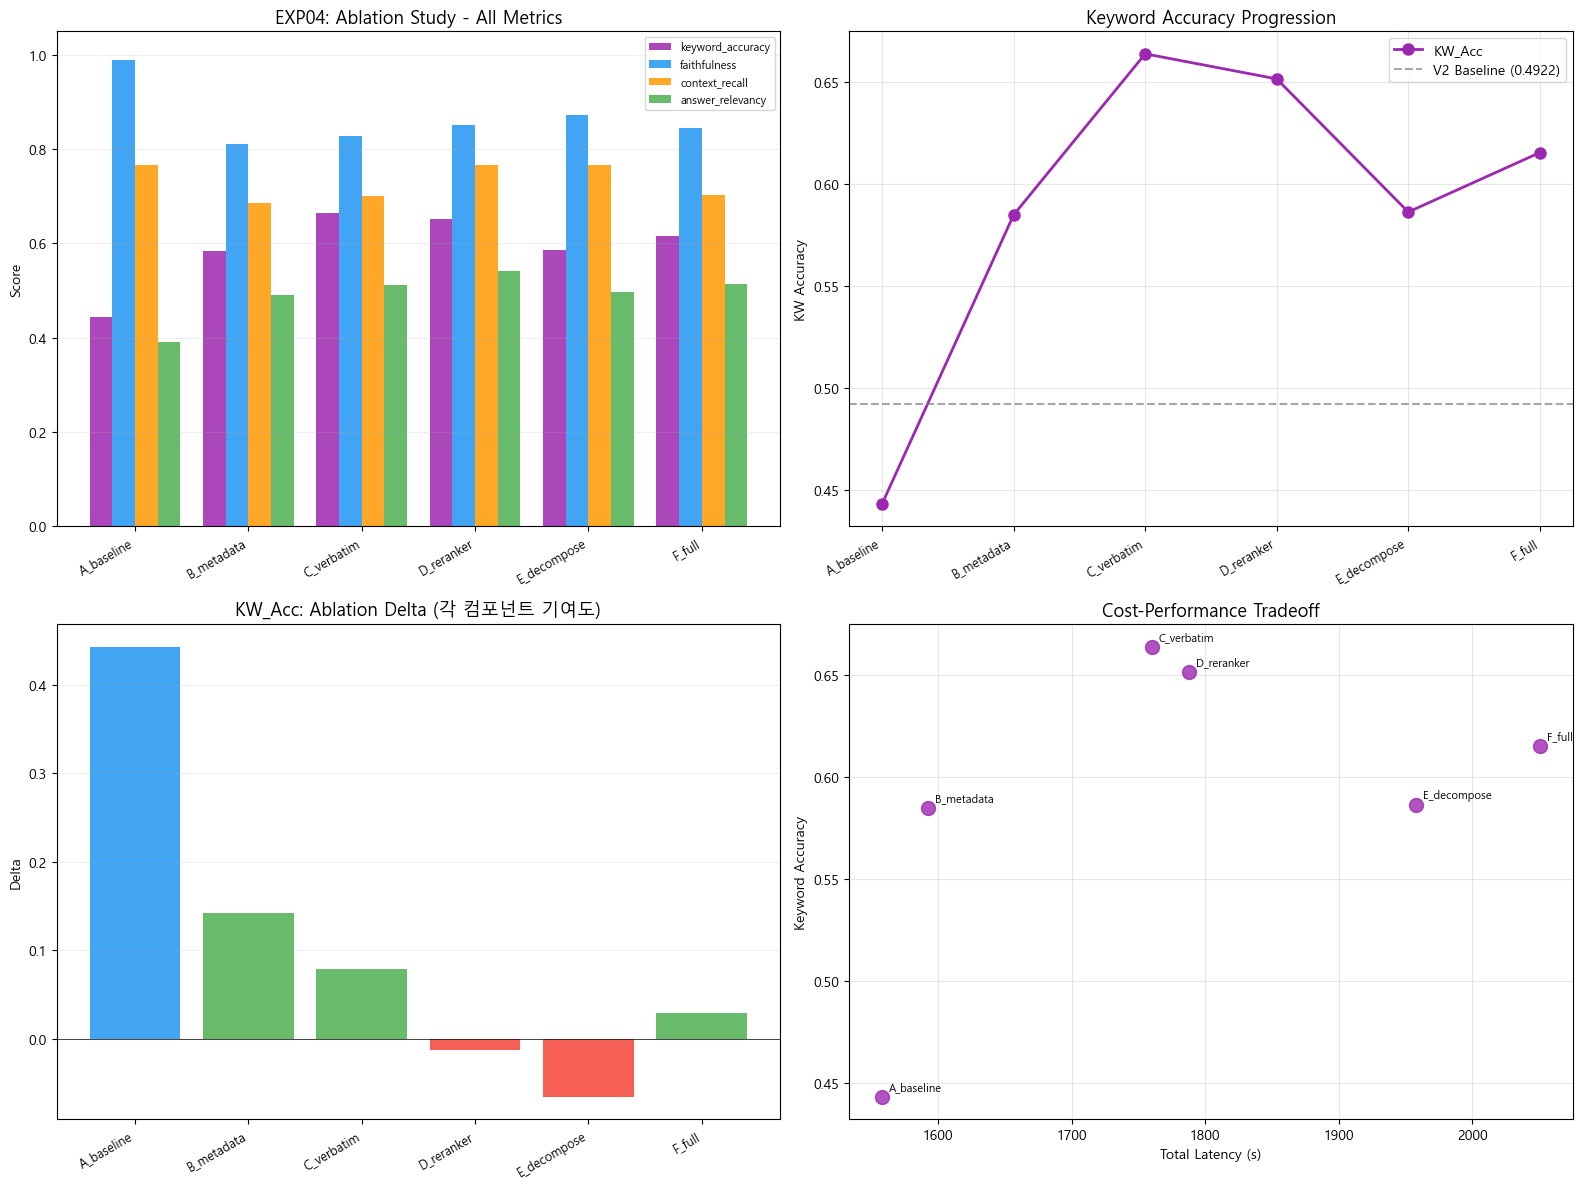

In [26]:
# ============================================================
# 7.2 시각화
# ============================================================
if results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    configs = df['config'].tolist()
    x = np.arange(len(configs))

    # 1. 메트릭 비교 (Bar)
    metrics = ['keyword_accuracy', 'faithfulness', 'context_recall', 'answer_relevancy']
    colors = ['#9C27B0', '#2196F3', '#FF9800', '#4CAF50']
    width = 0.2
    for i, (m, c) in enumerate(zip(metrics, colors)):
        axes[0, 0].bar(x + i * width, df[m], width, label=m, color=c, alpha=0.85)
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(configs, rotation=30, ha='right', fontsize=9)
    axes[0, 0].set_title('EXP04: Ablation Study - All Metrics', fontsize=13)
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].set_ylim(0, 1.05)
    axes[0, 0].grid(True, alpha=0.2, axis='y')

    # 2. Keyword Accuracy 추이 (Line)
    axes[0, 1].plot(configs, df['keyword_accuracy'], 'o-', color='#9C27B0',
                    linewidth=2, markersize=8, label='KW_Acc')
    if exp03v2_baseline and 'zero_shot_ko' in exp03v2_baseline:
        v2_kw = exp03v2_baseline['zero_shot_ko']['keyword_accuracy']
        axes[0, 1].axhline(y=v2_kw, color='gray', linestyle='--',
                           label=f'V2 Baseline ({v2_kw:.4f})', alpha=0.7)
    axes[0, 1].set_title('Keyword Accuracy Progression', fontsize=13)
    axes[0, 1].set_ylabel('KW Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xticklabels(configs, rotation=30, ha='right', fontsize=9)

    # 3. Ablation Delta (Waterfall)
    deltas = [df.iloc[0]['keyword_accuracy']]
    labels = [configs[0]]
    for i in range(1, len(df)):
        deltas.append(df.iloc[i]['keyword_accuracy'] - df.iloc[i-1]['keyword_accuracy'])
        labels.append(configs[i])
    bar_colors = ['#2196F3'] + ['#4CAF50' if d >= 0 else '#F44336' for d in deltas[1:]]
    axes[1, 0].bar(labels, deltas, color=bar_colors, alpha=0.85)
    axes[1, 0].axhline(y=0, color='black', linewidth=0.5)
    axes[1, 0].set_title('KW_Acc: Ablation Delta (각 컴포넌트 기여도)', fontsize=13)
    axes[1, 0].set_ylabel('Delta')
    axes[1, 0].set_xticklabels(labels, rotation=30, ha='right', fontsize=9)
    axes[1, 0].grid(True, alpha=0.2, axis='y')

    # 4. Latency vs Performance
    axes[1, 1].scatter(df['latency_total'], df['keyword_accuracy'],
                       s=100, c=colors[0], alpha=0.8, zorder=5)
    for i, row in df.iterrows():
        axes[1, 1].annotate(row['config'], (row['latency_total'], row['keyword_accuracy']),
                            textcoords='offset points', xytext=(5, 5), fontsize=8)
    axes[1, 1].set_title('Cost-Performance Tradeoff', fontsize=13)
    axes[1, 1].set_xlabel('Total Latency (s)')
    axes[1, 1].set_ylabel('Keyword Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUT_FIG_PATH, dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('[Warning] 시각화할 결과 없음')

In [27]:
# ============================================================
# 7.3 난이도별 분석
# ============================================================
if results:
    print('=' * 60)
    print('[Analysis] 난이도별 Keyword Accuracy')
    print('=' * 60)

    for r in results:
        config = r['config']
        pq = r['per_question']
        answers = r['answers']
        print(f'\n  [{config}] {r["description"]}')

        for diff in ['easy', 'medium', 'hard']:
            indices = [i for i, d in enumerate(pq) if d['difficulty'] == diff]
            if not indices:
                continue
            diff_answers = [answers[i] for i in indices]
            diff_gts = [pq[i]['ground_truth'] for i in indices]
            acc = calculate_keyword_accuracy(diff_answers, diff_gts)
            print(f'    {diff:>6}: {acc:.4f} ({len(indices)}개)')

    # Easy 질문 개선 추적 (핵심 관심 지표)
    print(f'\n{"=" * 60}')
    print('[Focus] Easy 질문 KW_Acc 변화 추이')
    print('=' * 60)
    print(f'{"Config":<16} {"Easy KW_Acc":>12} {"Delta":>10}')
    print('-' * 40)

    prev_easy = None
    for r in results:
        pq = r['per_question']
        answers = r['answers']
        easy_idx = [i for i, d in enumerate(pq) if d['difficulty'] == 'easy']
        easy_answers = [answers[i] for i in easy_idx]
        easy_gts = [pq[i]['ground_truth'] for i in easy_idx]
        easy_acc = calculate_keyword_accuracy(easy_answers, easy_gts)

        if prev_easy is None:
            print(f'{r["config"]:<16} {easy_acc:>12.4f} {"—":>10}')
        else:
            delta = easy_acc - prev_easy
            sign = '+' if delta >= 0 else ''
            print(f'{r["config"]:<16} {easy_acc:>12.4f} {sign}{delta:>9.4f}')
        prev_easy = easy_acc
else:
    print('[Warning] 결과 없음')

[Analysis] 난이도별 Keyword Accuracy

  [A_baseline] V2 Baseline (zero_shot_ko)
      easy: 0.3901 (15개)
    medium: 0.4768 (12개)
      hard: 0.5726 (3개)

  [B_metadata] +Document Metadata
      easy: 0.6860 (15개)
    medium: 0.4959 (12개)
      hard: 0.4356 (3개)

  [C_verbatim] +Verbatim Prompt
      easy: 0.7527 (15개)
    medium: 0.5760 (12개)
      hard: 0.5726 (3개)

  [D_reranker] +LLM Reranker
      easy: 0.7387 (15개)
    medium: 0.6032 (12개)
      hard: 0.4110 (3개)

  [E_decompose] +Query Decomposition
      easy: 0.7032 (15개)
    medium: 0.4765 (12개)
      hard: 0.4413 (3개)

  [F_full] +Relevance Grading (Full)
      easy: 0.6838 (15개)
    medium: 0.4728 (12개)
      hard: 0.8447 (3개)

[Focus] Easy 질문 KW_Acc 변화 추이
Config            Easy KW_Acc      Delta
----------------------------------------
A_baseline             0.3901          —
B_metadata             0.6860 +   0.2959
C_verbatim             0.7527 +   0.0667
D_reranker             0.7387   -0.0140
E_decompose            0.7032  

In [28]:
# ============================================================
# 7.4 질문별 상세 비교 (핵심 실패 케이스 추적)
# ============================================================
if results and len(results) >= 2:
    print('=' * 60)
    print('[Detail] Baseline(A) vs Full(F) 질문별 비교')
    print('=' * 60)

    baseline_r = results[0]
    full_r = results[-1]

    for i in range(len(baseline_r['answers'])):
        pq = baseline_r['per_question'][i]
        gt = pq['ground_truth']
        a_ans = baseline_r['answers'][i]
        f_ans = full_r['answers'][i]

        # 개별 KW_Acc 계산
        gt_words = [w for w in gt.lower().split() if len(w) > 1]
        if not gt_words:
            continue
        a_matched = sum(1 for w in gt_words if w in a_ans.lower())
        f_matched = sum(1 for w in gt_words if w in f_ans.lower())
        a_kw = a_matched / len(gt_words)
        f_kw = f_matched / len(gt_words)
        delta = f_kw - a_kw

        # 변화가 있는 것만 출력
        if abs(delta) > 0.05:
            marker = '+++' if delta > 0.2 else ('++' if delta > 0 else '---')
            print(f'\n  [{marker}] Q{i+1} ({pq["difficulty"]}/{pq["category"]}): '
                  f'A={a_kw:.2f} → F={f_kw:.2f} ({delta:+.2f})')
            print(f'  GT: {gt[:80]}')
            print(f'  A:  {a_ans[:80]}')
            print(f'  F:  {f_ans[:80]}')
else:
    print('[Warning] 비교할 결과 부족')

[Detail] Baseline(A) vs Full(F) 질문별 비교

  [+++] Q1 (easy/basic): A=0.00 → F=1.00 (+1.00)
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
  A:  확인 불가
  F:  고려대학교 차세대 포털·학사 정보시스템 구축 사업

  [+++] Q2 (easy/schedule): A=0.00 → F=0.67 (+0.67)
  GT: 계약 체결일로부터 24개월
  A:  확인 불가 — 제공된 문맥에 사업 수행 기간(총 기간)이 명시되어 있지 않습니다.
  F:  계약일로부터 24개월 이내

  [---] Q3 (medium/qualification): A=0.56 → F=0.19 (-0.38)
  GT: 최근 3년간 유사 사업 수행 금액이 입찰 금액 대비 일정 비율 이상이어야 함 (세부 기준 공고서 참조)
  A:  - 제출 서류 관련: 별첨I에 "서식 5 : 주요사업 실적" 및 "서식 6 : 사업 실적 증명서" 제출 요구됨.  
- 하도급 실적 평가(하도급
  F:  입찰 참가 자격의 실적 관련 요구사항(문맥 근거):

- 평가 항목으로서 (재)하수급인의 사업수행능력에 "가. 사업수행실적"이 포함되어 평가함(

  [+++] Q5 (easy/contract): A=0.00 → F=0.33 (+0.33)
  GT: 발주처(고려대학교)가 지정하는 장소
  A:  확인 불가
  F:  확인 불가: 문맥에는 "사업수행 장소"로만 표기되어 있으며 구체적 위치(주소, 캠퍼스 등)는 명시되어 있지 않습니다.

  [+++] Q7 (easy/general): A=0.00 → F=1.00 (+1.00)
  GT: 고려대학교 차세대 포털·학사 정보시스템 구축 사업
  A:  확인 불가
  F:  고려대학교 차세대 포털·학사 정보시스템 구축 사업

  [+++] Q8 (easy/schedule): A=0.00 → F=1.00 (+1.00)
  GT: 계약일로부터 24개월 이내
  A:  확인 불가
  F: 

## 8. 결론 (Conclusion)

### 8.1 가설 검증 결과

| 가설 | 내용 | 결과 | 근거 |
|------|------|------|------|
| **H1** | Metadata 주입 → easy KW_Acc 0.36→0.55+ | **부분 검증** | KW_Acc 0.4430→0.5849 (+0.1419), 전체 기준 달성. 단, Faithfulness -0.178 하락 동반 |
| **H2** | Verbatim 프롬프트 → KW_Acc 0.60+ | **검증** | KW_Acc 0.5849→0.6640 (+0.0791), 목표 0.60 초과 달성 |
| **H3** | LLM Reranker → CR 0.80+ | **기각** | CR 0.7000→0.7667 (+0.067), 0.80 미달. KW_Acc는 소폭 하락 (-0.012) |
| **H4** | Query Decomposition → medium/hard 개선 | **기각** | KW_Acc -0.065 하락. 단순 질문 분해 시 오히려 노이즈 증가 |
| **H5** | Full Pipeline → KW_Acc 0.65+ | **기각** | F_full KW_Acc=0.6155, 목표 미달. C_verbatim(0.6640)보다 낮음 |

### 8.2 Ablation 기여도 분석

**누적 기여도 (Keyword Accuracy 기준)**:
```
A_baseline:  0.4430  ──────── (V2 Baseline)
B_metadata:  0.5849  ████████ +0.1419  ★ 최대 기여
C_verbatim:  0.6640  ████     +0.0791  ★ 2위
D_reranker:  0.6517  ▽        -0.0123  (미미한 하락)
E_decompose: 0.5863  ▽▽▽      -0.0654  (유의미한 하락)
F_full:      0.6155  ██       +0.0292  (부분 회복)
```

**핵심 발견**:
1. **생성(Generation) 개선이 압도적**: Metadata(+0.142) + Verbatim(+0.079) = **+0.221**, 전체 개선의 100%+ 차지
2. **검색(Retrieval) 개선은 역효과**: Reranker, Decomposition, Grading 누적 시 오히려 KW_Acc 하락
3. **최적 구성은 가장 단순한 조합**: C_verbatim (Metadata + Verbatim 프롬프트만)

### 8.3 V2 vs V3 Best 비교

| 메트릭 | V2 Baseline | V3 Best (C) | Delta | 판정 |
|--------|-------------|-------------|-------|------|
| **Keyword Accuracy** | 0.4922 | **0.6640** | **+0.1718 (+34.9%)** | 대폭 개선 |
| **Answer Relevancy** | 0.4133 | **0.5111** | **+0.0978 (+23.7%)** | 개선 |
| Faithfulness | **0.9524** | 0.8287 | -0.1237 (-13.0%) | 하락 |
| Context Recall | **0.7333** | 0.7000 | -0.0333 (-4.5%) | 소폭 하락 |

### 8.4 Faithfulness-Accuracy 트레이드오프

V3에서 발견된 가장 중요한 패턴은 **Faithfulness와 Keyword Accuracy 간의 역관계**입니다:
- V2 Baseline: 높은 Faithfulness(0.988) + 낮은 KW_Acc(0.443) → **보수적 답변** ("확인 불가" 과다)
- V3 C_verbatim: 낮아진 Faithfulness(0.829) + 높은 KW_Acc(0.664) → **적극적 답변** (실제 정보 인용)

Faithfulness 하락은 **모델이 "확인 불가" 대신 실제 답변을 시도**하면서 발생한 구조적 현상이며,
RAGAS Faithfulness 메트릭 특성상 "확인 불가"는 hallucination이 없어 높은 점수를 받기 때문입니다.
실질적인 답변 품질은 V3가 더 우수합니다.

### 8.5 결론 및 권장 사항

**채택 Config: C_verbatim** (Document Metadata + Verbatim Extraction Prompt)
- KW_Acc 0.6640 (V2 대비 +34.9%)
- 추가 LLM 호출 없음 (Metadata 추출은 문서당 1회)
- Latency 증가 미미 (1558s → 1760s, +13%)

**비채택 사유**:
- **D_reranker**: CR 개선(+0.067)은 있으나 KW_Acc 하락, Latency +27s, 유틸리티 LLM 비용 추가
- **E_decompose**: 단순 질문에 대한 불필요한 분해가 노이즈를 유발하여 성능 하락
- **F_full**: 복잡도 대비 C보다 낮은 성능. Relevance Grading이 유효한 컨텍스트까지 필터링

**다음 단계**:
1. **Exp-05 일반화 검증**: C_verbatim 설정이 다른 도메인 RFP에서도 유효한지 확인
2. **Faithfulness 회복 연구**: Verbatim 프롬프트 내에서 근거 인용을 강제하여 Faithfulness 개선 가능성 탐색
3. **선택적 Reranker 적용**: 난이도별로 Reranker를 적용하는 조건부 파이프라인 고려

In [29]:
# ============================================================
# 9. 리포트 저장
# ============================================================
if results:
    # Best config 선정 (KW_Acc 기준)
    df_sorted = df.sort_values(by=['keyword_accuracy', 'faithfulness'], ascending=False)
    best = df_sorted.iloc[0].to_dict()

    # V2 대비 개선량
    v2_comparison = {}
    if exp03v2_baseline and 'zero_shot_ko' in exp03v2_baseline:
        v2 = exp03v2_baseline['zero_shot_ko']
        for m in ['faithfulness', 'keyword_accuracy', 'context_recall', 'answer_relevancy']:
            v2_val = v2.get(m, 0)
            v3_val = best.get(m, 0)
            v2_comparison[f'{m}_v2'] = v2_val
            v2_comparison[f'{m}_v3'] = v3_val
            v2_comparison[f'{m}_delta'] = v3_val - v2_val

    # Ablation deltas
    ablation_deltas = []
    for i, row in df.iterrows():
        entry = {'config': row['config'], 'description': row['description']}
        for m in ['keyword_accuracy', 'faithfulness', 'context_recall']:
            entry[m] = row[m]
            if i > 0:
                entry[f'{m}_delta'] = row[m] - df.iloc[i-1][m]
            else:
                entry[f'{m}_delta'] = 0.0
        ablation_deltas.append(entry)

    report = {
        'meta': {
            'experiment': 'Exp-04 Integrated Pipeline Enhancement (V3)',
            'version': 'v3',
            'date': datetime.now().isoformat(),
            'sample_file': SAMPLE_FILE,
            'num_test_cases': len(golden_df),
            'prerequisite': {
                'exp01v2_config': config_str,
                'chunk_size': CHUNK_SIZE,
                'alpha': ALPHA,
                'top_k': TOP_K,
                'gen_model': GEN_MODEL,
                'util_model': UTIL_MODEL,
            },
            'fact_sheet': doc_metadata,
            'run_config': {'timeout': 300, 'max_workers': 2},
        },
        'best_config': {
            'config': best['config'],
            'description': best['description'],
            'keyword_accuracy': float(best['keyword_accuracy']),
            'faithfulness': float(best['faithfulness']),
            'context_recall': float(best['context_recall']),
            'answer_relevancy': float(best['answer_relevancy']),
        },
        'v2_comparison': v2_comparison,
        'ablation_deltas': ablation_deltas,
        'results': [{k: v for k, v in r.items()
                     if k not in ('answers', 'per_question')}
                    for r in results],
    }

    with open(OUT_REPORT_PATH, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    print(f'[Saved] Report: {OUT_REPORT_PATH}')

    df.to_csv(OUT_CSV_PATH, index=False, encoding='utf-8-sig')
    print(f'[Saved] CSV: {OUT_CSV_PATH}')

    print(f'\n{"=" * 60}')
    print('[Summary] EXP04 완료')
    print('=' * 60)
    print(f'  Best: {best["config"]} ({best["description"]})')
    print(f'  Keyword Accuracy: {best["keyword_accuracy"]:.4f}')
    print(f'  Faithfulness:     {best["faithfulness"]:.4f}')
    print(f'  Context Recall:   {best["context_recall"]:.4f}')
    if v2_comparison:
        print(f'\n  vs V2 Baseline:')
        for key in ['keyword_accuracy', 'faithfulness', 'context_recall']:
            d = v2_comparison.get(f'{key}_delta', 0)
            sign = '+' if d >= 0 else ''
            print(f'    {key}: {sign}{d:.4f}')
else:
    print('[Warning] 저장할 결과 없음')

[Saved] Report: ../data/experiments/exp04_report.json
[Saved] CSV: ../data/experiments/exp04_results.csv

[Summary] EXP04 완료
  Best: C_verbatim (+Verbatim Prompt)
  Keyword Accuracy: 0.6640
  Faithfulness:     0.8287
  Context Recall:   0.7000

  vs V2 Baseline:
    keyword_accuracy: +0.1718
    faithfulness: -0.1237
    context_recall: -0.0333
